# How to SOSS, part 1: reading data & tracing
---

**Author: Nestor Espinoza (nespinoza@stsci.edu)**

This version of the notebook is a copy of the orginal for Tyler Baines to test/learn more about the upcoming training-project for NIRISS/SOSS.

Let's start by loading some libraries we'll be using:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import transitspectroscopy as ts

from jwst import datamodels
from scipy.interpolate import splev, splrep

In [2]:
sns.set_style('ticks')

In [3]:
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.dpi'] = 200

## 1. Data reading

Let's read the data. This will read the rates per integration:

In [4]:
datafolder = '/ifs/jwst/wit/witserv/data18/nis_commissioning/nis-034_1541/data/01541/'

In [5]:
import os
# print(os.getcwd())
if os.path.isdir(datafolder[:-1]):
    print(f"{datafolder}: is an active directory")
else:
    print(f"{datafolder}: is not an active directory")

/ifs/jwst/wit/witserv/data18/nis_commissioning/nis-034_1541/data/01541/: is an active directory


NOTE: I splited the block of code into a single cell, it was taking forever to load the data. Not sure why this would be a problem.

In [6]:
tso1 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg001_nis_rateints.fits')

In [7]:
tso2 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg002_nis_rateints.fits')

In [8]:
tso3 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg003_nis_rateints.fits')

In [9]:
tso4 = datamodels.open(datafolder + 'jw01541001001_04101_00001-seg004_nis_rateints.fits')

Data is divided in segments so they are easier to process, but for our application we don't need to have them separated. So we'll join all in single set of arrays: 

In [10]:
tso_obs = [tso1, tso2, tso3, tso4]

# Data:
tso = np.vstack([obs.data for obs in tso_obs])

# Errors:
tso_err = np.vstack([obs.err for obs in tso_obs])

In [23]:
tso.shape

(572, 256, 2048)

To trace the spectra for this set of exercises, we'll do it on the median image (i.e., combine all the frames from all the integrations) to have a very high signal-to-noise frame to work on:

In [19]:
median_tso = np.median(tso, axis = 0) 

In [20]:
median_tso.shape

(256, 2048)

## 2. Let's trace!

Let's trace the spectra for Orders 1, 2 and 3. To do this, we need to define some parameters for the cross-correlation we will do:

In [22]:
ccf_parameters = [-7.5, 3.0, 7.5, 3.0]

And now we need to define some starting points for the tracing algorithm. To this end we cross correlate one of the columns, and use that as our starting points. Let's plot the median frame first to identify these starting points by eye (they should be similar for different datasets):

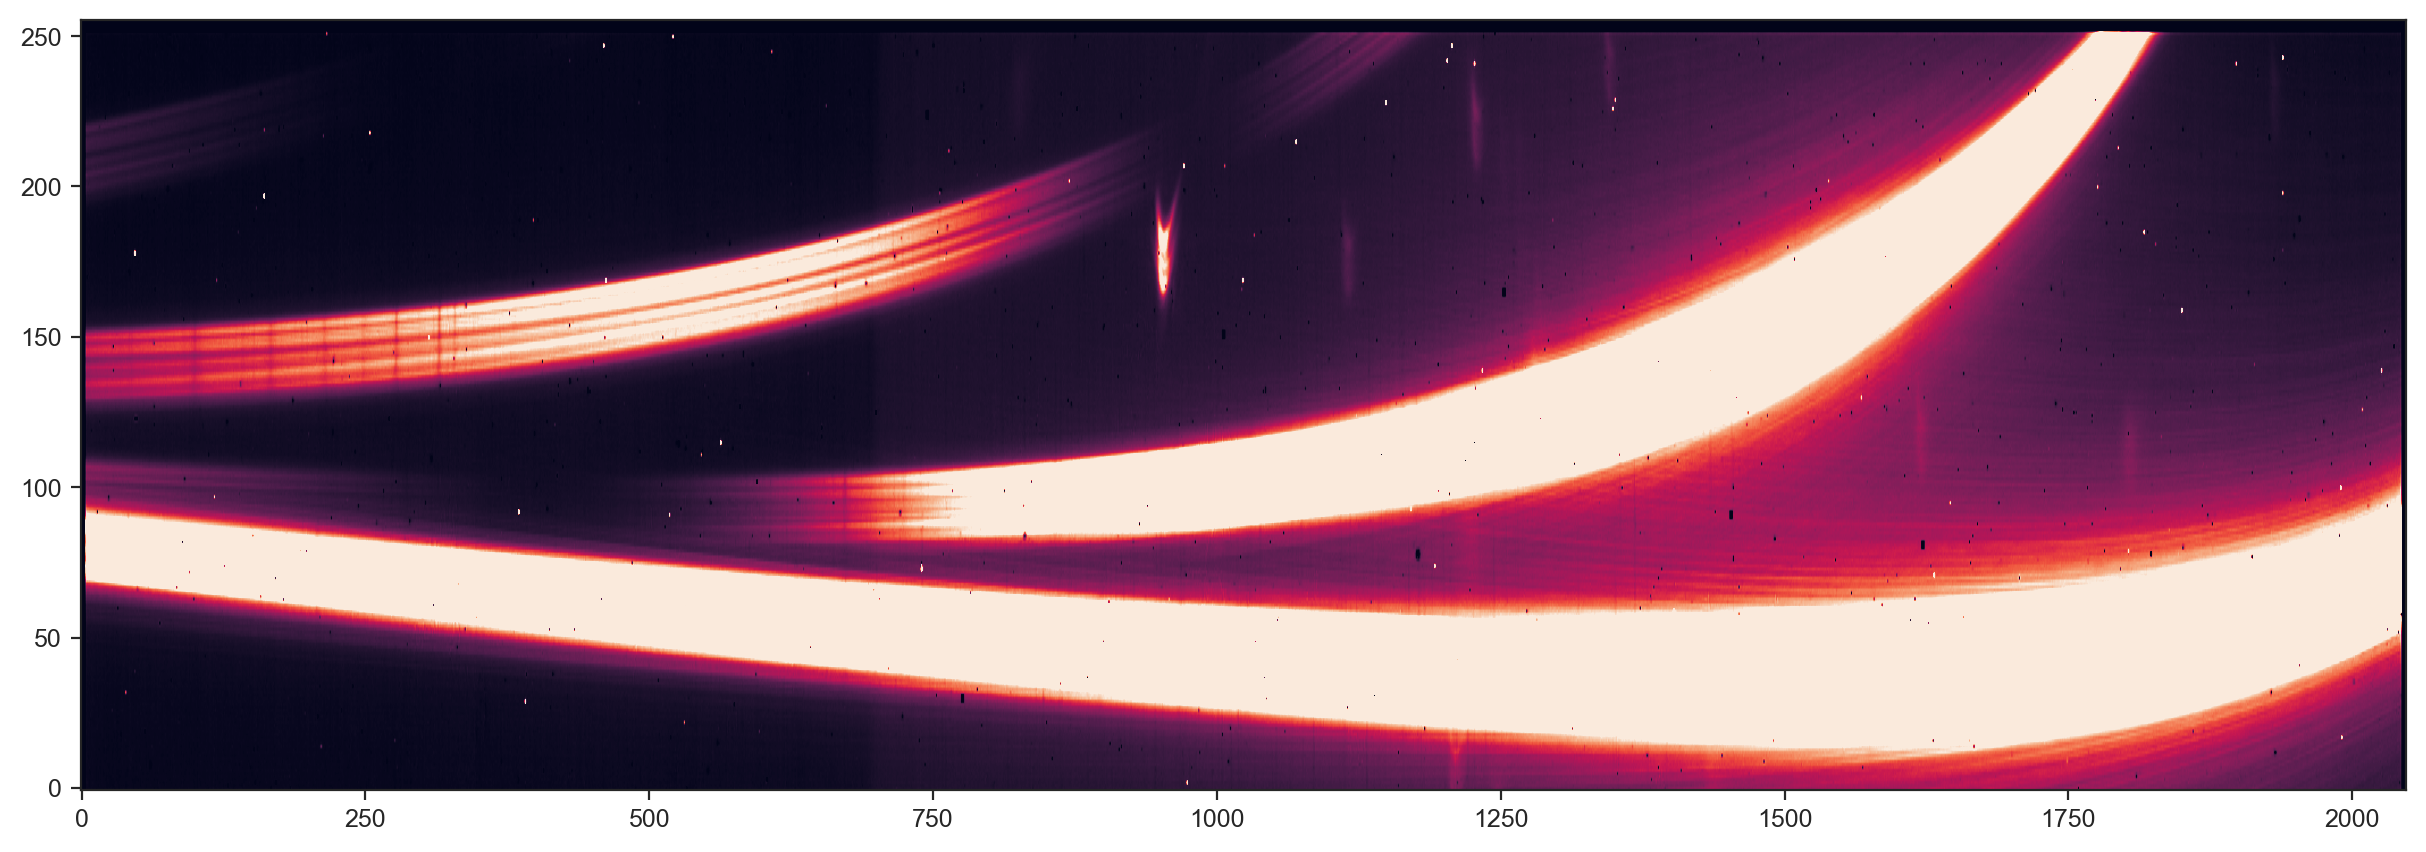

In [23]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

im.set_clim(2,30)

Now let's cross-correlate gaussians against some columns based on that. For instance, we cross-correlate Order 1 on the very right-most column, Order 2 around column 1750 (which is where it more or less Order 2 starts) and order 3 at around column 900:

In [24]:
help(ts.spectroscopy.get_ccf)

Help on function get_ccf in module transitspectroscopy.spectroscopy:

get_ccf(x, y, function='gaussian', parameters=None, pixelation=False, lag_step=0.001)
    Function that obtains the CCF between input data defined between x and y and a pre-defined function.
    
    Parameters
    ----------
    
    x : numpy.array
        Array containing the values at which each of the y-values are defined.
    y : numpy.array
        Array containing the input values.
    function : string or function
        String containing the function against which the CCF wants to be computed. Default is 'gaussian'; can also be 'double gaussian'. Alternatively it can be 
        a function of choice that needs to be able to be evaluated at `x`.
    parameters : list
        Parameters for the input function. For the gaussian, the first item identifies the mean, the second the standard deviation. For the double gaussian, the first two 
        are the mean and standard deviation of the first gaussian, the l

In [25]:
lags1, ccf1 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 2043], 
                                         function = 'double gaussian', parameters = ccf_parameters,)

lags2, ccf2 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 1750], 
                                         function = 'double gaussian', parameters = ccf_parameters)

lags3, ccf3 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 900], 
                                         function = 'double gaussian', parameters = ccf_parameters)

Let's plot and define the starting points from these CCFs:

(30.0, 150.0)

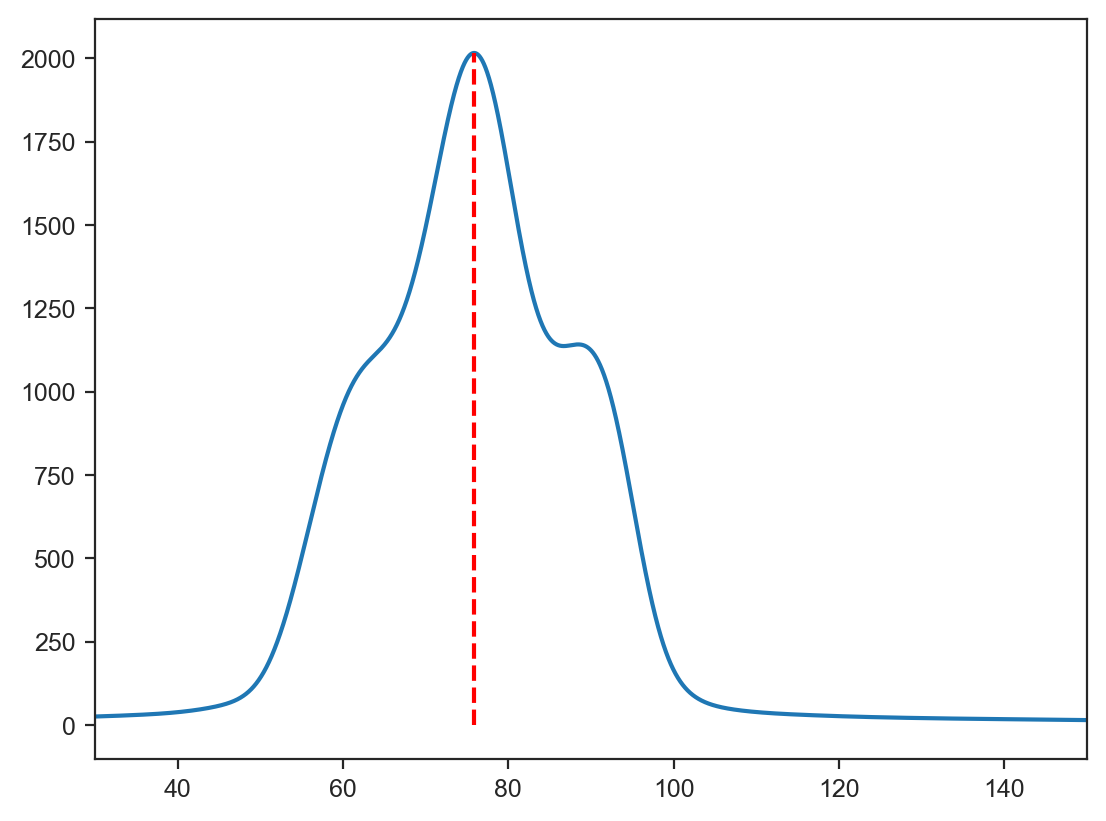

In [26]:
idx = np.where(np.max(ccf1) == ccf1)[0]
ystart1 = lags1[idx][0]

plt.plot(lags1, ccf1, label='ccf1')
plt.vlines(ystart1, 0, np.max(ccf1), linestyle='--', color='r')
plt.xlim(30,150)
# plt.plot([ystart1, ystart1], [0, np.max(ccf1)], 'r--')

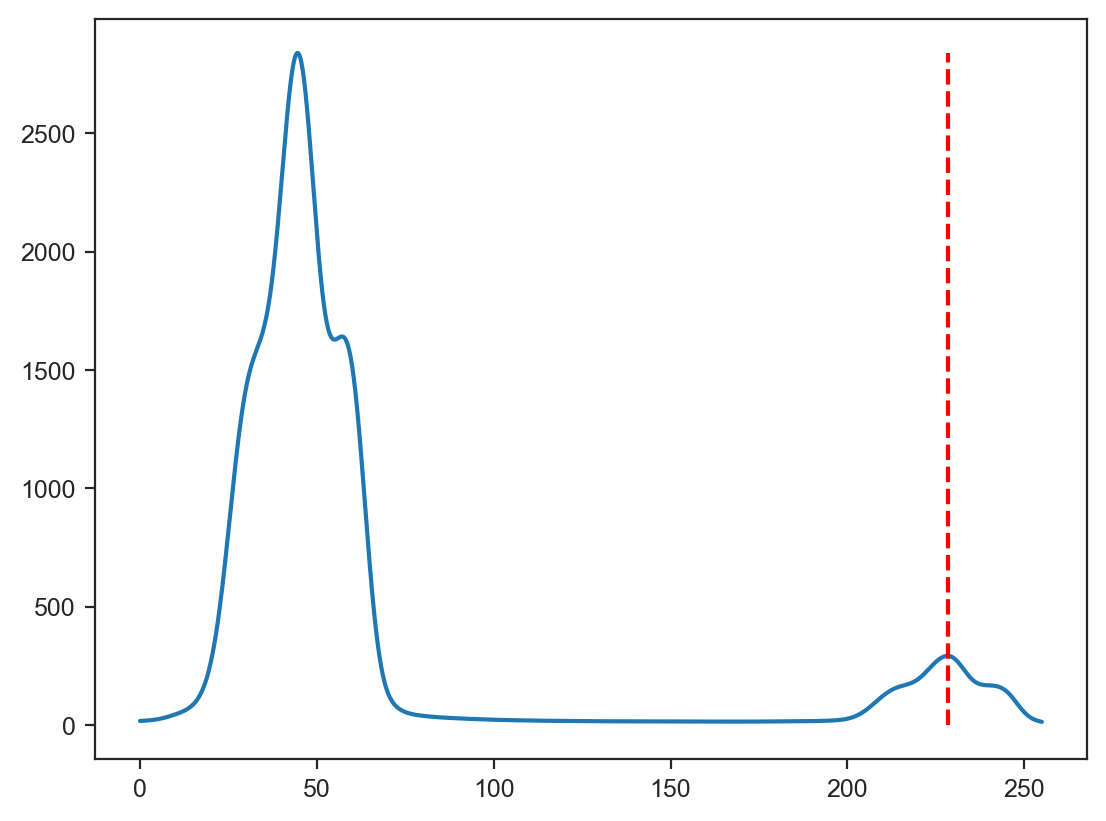

In [27]:
idx_large = np.where(lags2>200)[0]
ccf2 = np.array(ccf2)
idx = np.where( np.max(ccf2[idx_large]) == ccf2[idx_large] )[0]
ystart2 = lags2[idx_large][idx][0]

plt.plot(lags2, ccf2)
plt.plot([ystart2, ystart2], [0, np.max(ccf2)], 'r--')

(0.0, 100.0)

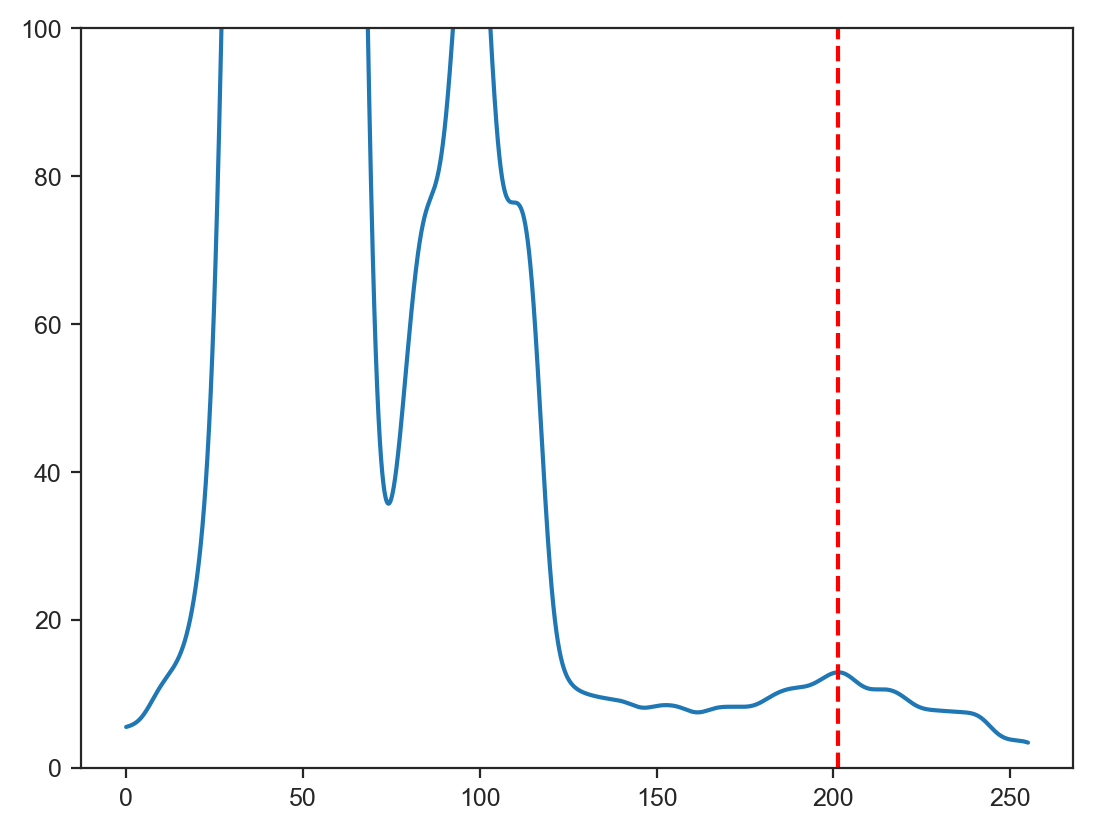

In [28]:
idx_large = np.where(lags3>150)[0]
ccf3 = np.array(ccf3)

idx = np.where( np.max(ccf3[idx_large]) == ccf3[idx_large] )[0]
ystart3 = lags3[idx_large][idx][0]

plt.plot(lags3, ccf3)
plt.plot([ystart3, ystart3], [0, np.max(ccf3)], 'r--')
plt.ylim(0,100)

Let's trace. Order 1 first:

In [29]:
x1, y1 = ts.spectroscopy.trace_spectrum(median_tso, 
                                        np.zeros(median_tso.shape), 
                                        xstart = 2043, 
                                        ystart = ystart1, 
                                        xend = 4, 
                                        ccf_function = 'double gaussian', 
                                        ccf_parameters = ccf_parameters)

Now Order 2:

In [30]:
x2_end, x2_start = 600, 1750

x2, y2 = ts.spectroscopy.trace_spectrum(median_tso, 
                                        np.zeros(median_tso.shape), 
                                        xstart = x2_start, ystart = ystart2, xend = x2_end, 
                                        ccf_function = 'double gaussian', 
                                        ccf_parameters = ccf_parameters, 
                                        y_tolerance = 4)

And Order 3:

In [31]:
x3_end, x3_start = 4, 900

x3, y3 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                        xstart = x3_start, ystart = ystart3, xend = x3_end, 
                                        ccf_function = 'double gaussian', 
                                        ccf_parameters = ccf_parameters, 
                                        y_tolerance = 4)

Let's see how we did:

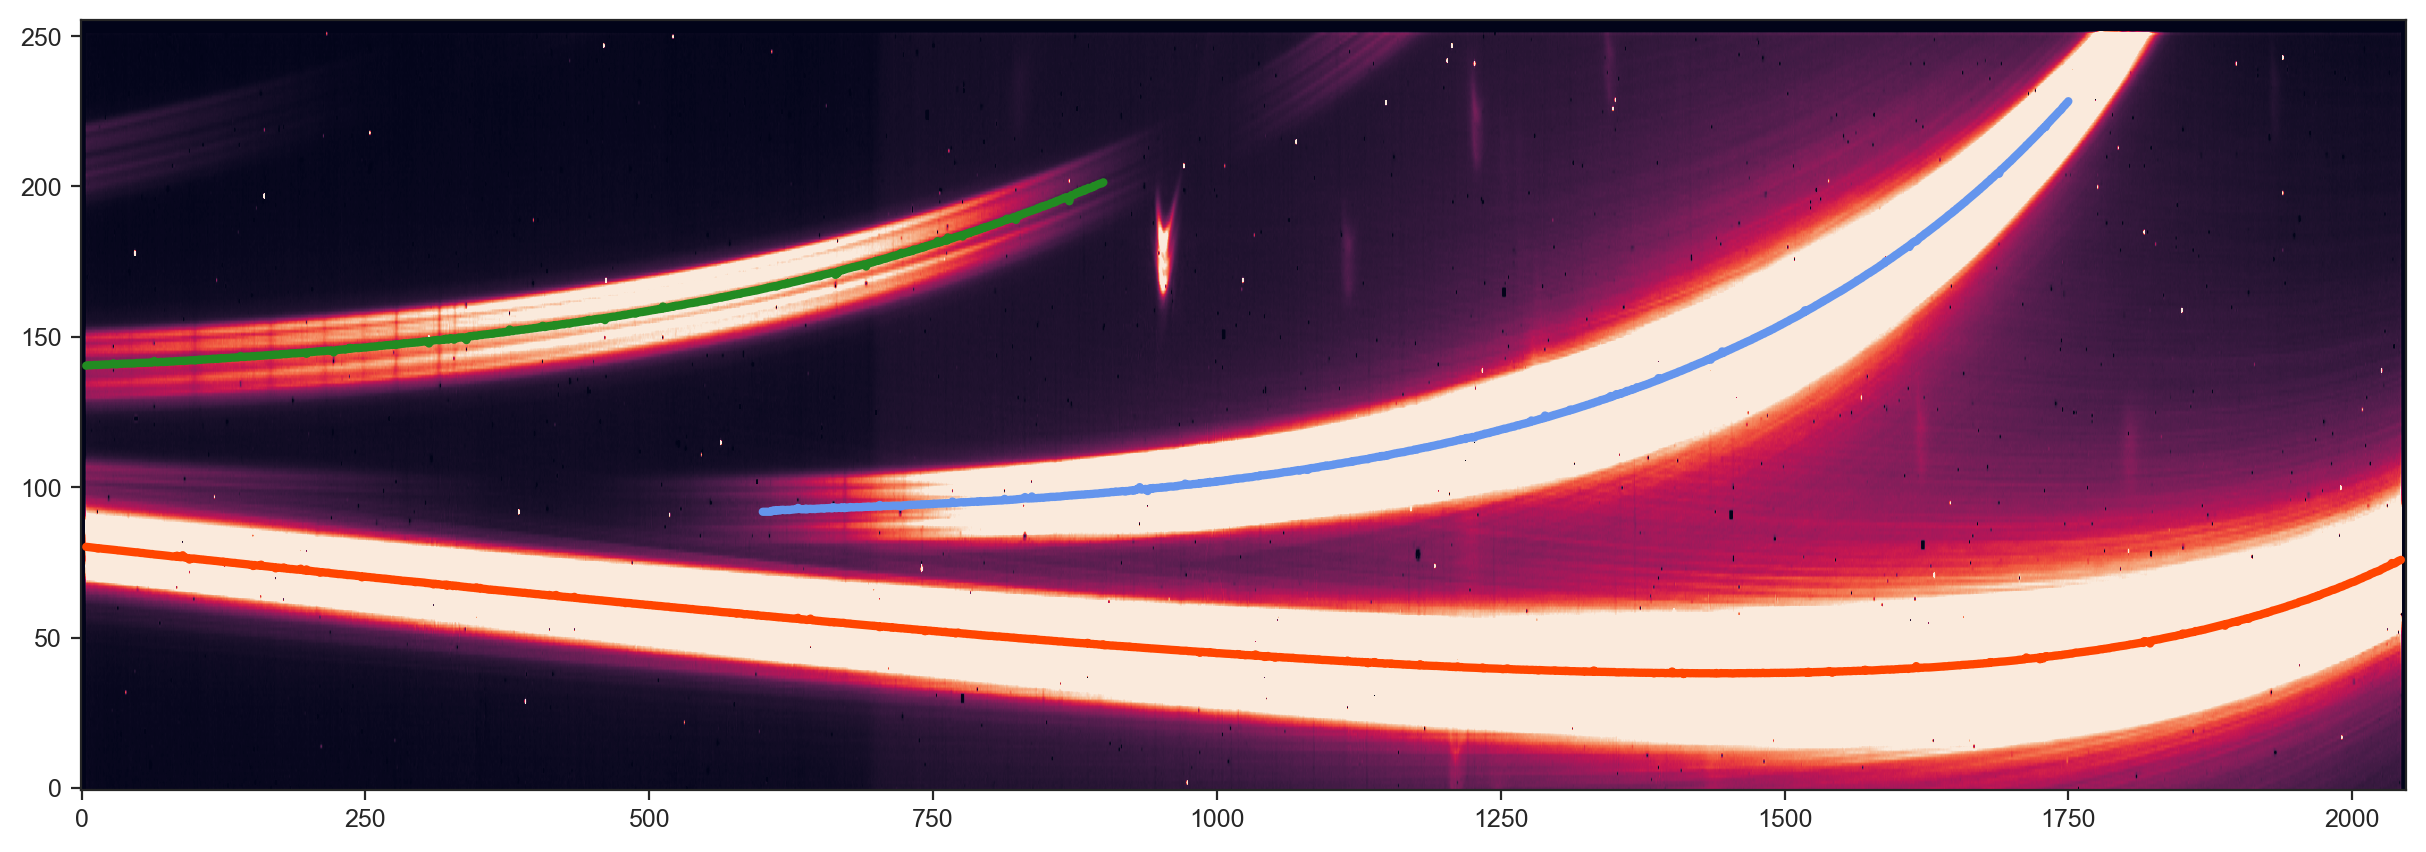

In [32]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, aspect = 'auto')

plt.plot(x1, y1, color = 'orangered', lw = 3)
plt.plot(x2, y2, color = 'cornflowerblue', lw = 3)
plt.plot(x3, y3, color = 'forestgreen', lw = 3)

im.set_clim(2,30)

That looks pretty good! We can also smooth those traces via splines (polynomials are not very good at this level of precision --- traces are just _too good!_):

In [33]:
x_knots1 = [[6, 1200-5], [1200, 1500-5], [1500, 1700-5],[1700, 2041]]
nknots1 = [4,2,3,4]

x_knots2 = [[601, 850-5], [850, 1100-5],[1100,1749]]
nknots2 = [2, 2, 5]

In [34]:
_, sfit1 = ts.utils.fit_spline(x1, y1, nknots = nknots1, x_knots = x_knots1)
_, sfit2 = ts.utils.fit_spline(x2, y2, nknots = nknots2, x_knots = x_knots2)
_, sfit3 = ts.utils.fit_spline(x3, y3, nknots = 10)

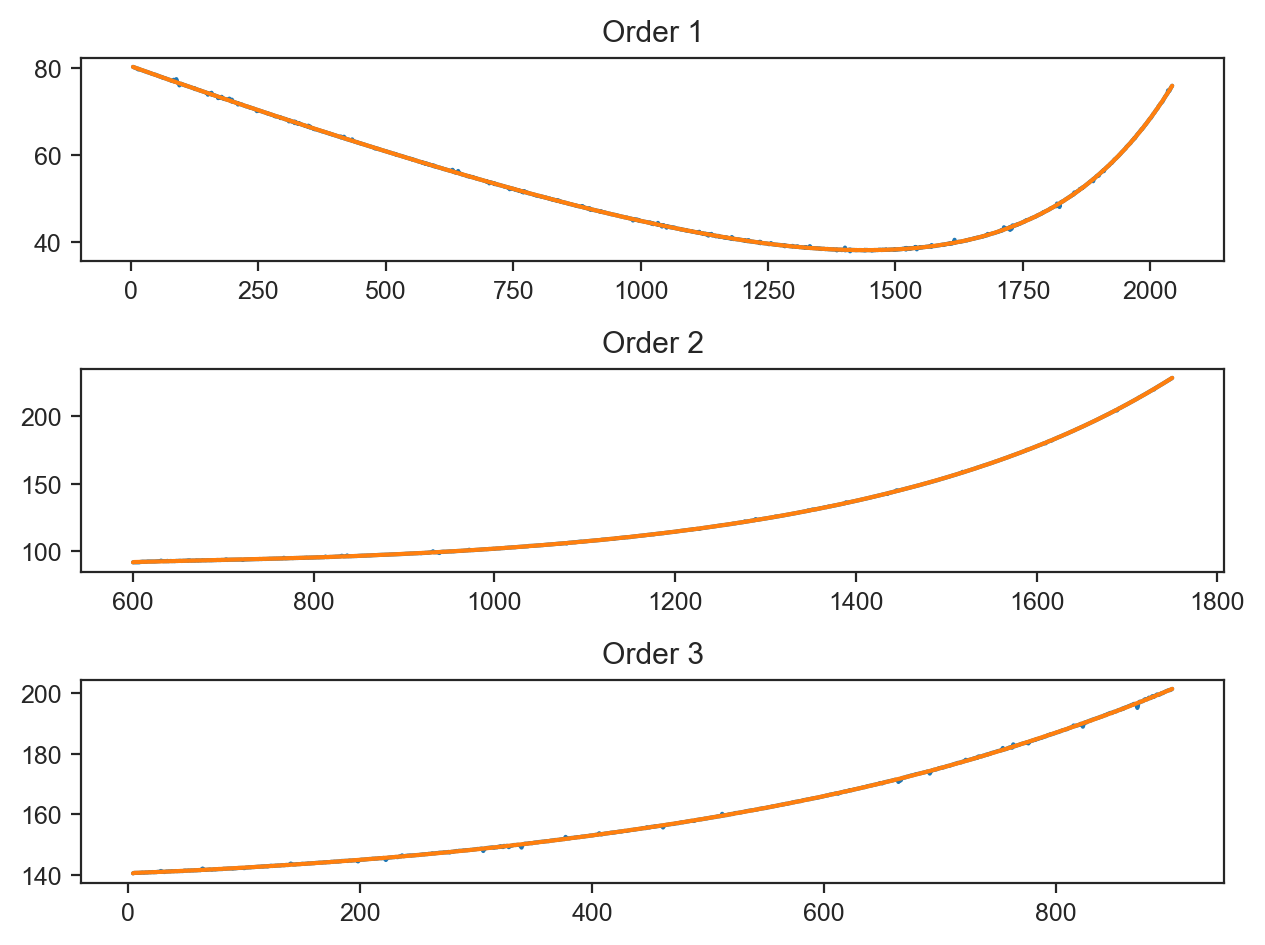

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True)

ax1.set_title('Order 1')
ax1.plot(x1, y1, label='measured trace')
ax1.plot(x1, sfit1, label='spline trace')

ax2.set_title('Order 2')
ax2.plot(x2, y2, label='measured trace')
ax2.plot(x2, sfit2, label='spline trace')

ax3.set_title('Order 3')
ax3.plot(x3, y3, label='measured trace')
ax3.plot(x3, sfit3, label='spline trace')

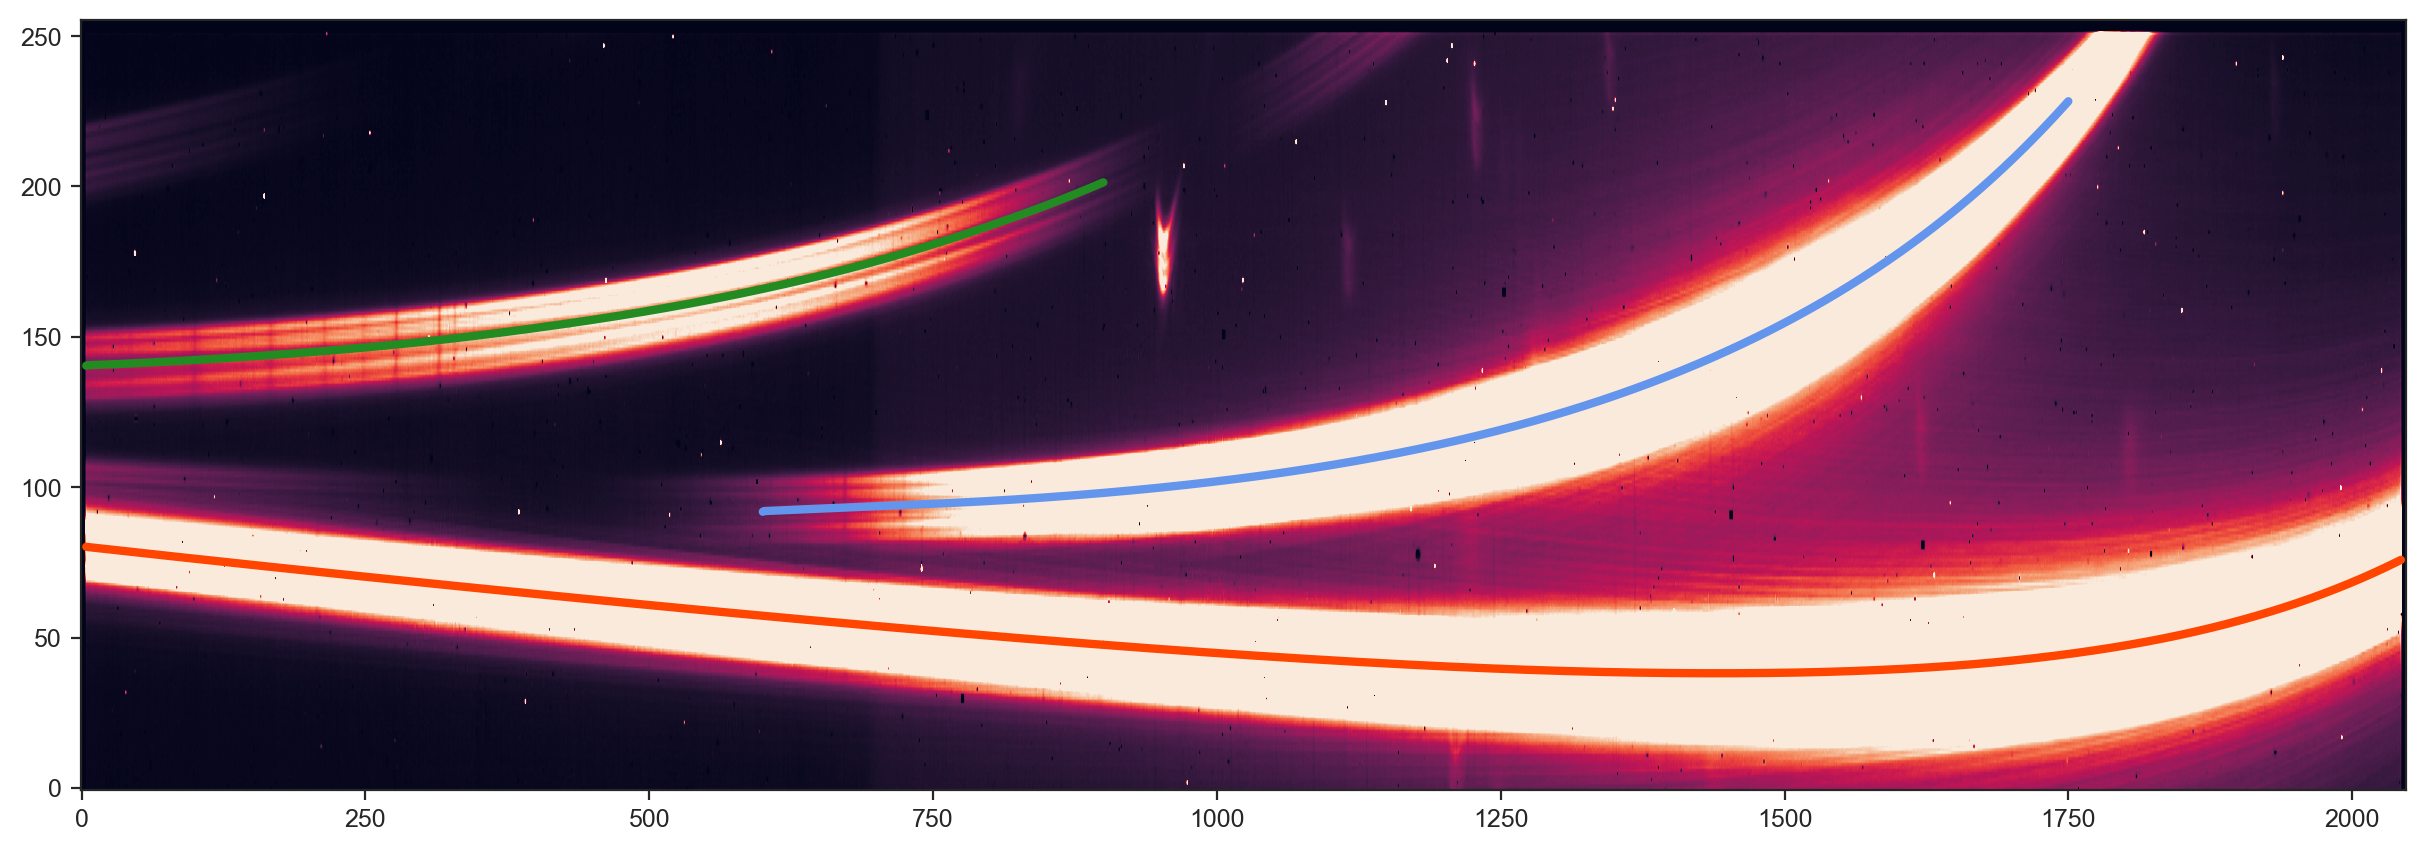

In [36]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

plt.plot(x1, sfit1, color = 'orangered', lw = 3)
plt.plot(x2, sfit2, color = 'cornflowerblue', lw = 3)
plt.plot(x3, sfit3, color = 'forestgreen', lw = 3)

im.set_clim(2,30)

## 3. Getting pupil wheel & filter positions

So, how do we extract pupil and filter wheel positions? The `datamodels` make this very easy! We can ask directly where those are:

In [37]:
tso1.search('pupil')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    ├─pupil (str): GR700XD
    └─pupil_position (float): 245.8984379999796

In [38]:
tso1.search('filter')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    ├─filter (str): CLEAR
    └─filter_position (float): 74.87733460000561

If you want the numbers directly, you can use the tree of keys given up:

In [39]:
tso1.meta.instrument.pupil_position

245.8984379999796

In [40]:
tso1.meta.instrument.filter_position

74.87733460000561

And that's it!

TB: From here lets look at some addition things. 

In [11]:
pupil_positions = [obs.meta.instrument.pupil_position for obs in tso_obs]
filter_positions = [obs.meta.instrument.filter_position for obs in tso_obs]

In [12]:
pupil_positions

[245.8984379999796, 245.8984379999796, 245.8984379999796, 245.8984379999796]

In [16]:
np.allclose(pupil_positions, pupil_positions[0])

True

In [13]:
filter_positions

[74.87733460000561, 74.87733460000561, 74.87733460000561, 74.87733460000561]

In [17]:
np.allclose(filter_positions, filter_positions[0])

True

For a given set of files, the pupil and filter wheel appear to both be in the same position when observations are taken so there no slight adjustment. 

In [92]:
from dataclasses import dataclass

In [ ]:
@dataclass
class TimeSeriesObservation:
    data: np.ndarray
    filename: str
    pupil_position: float
    filter_position: float
    

In [43]:
def test_func(image):
    lags1, ccf1 = ts.spectroscopy.get_ccf(np.arange(image.shape[0]), image[:, 2043], 
                                         function = 'double gaussian', parameters = ccf_parameters,)

    lags2, ccf2 = ts.spectroscopy.get_ccf(np.arange(image.shape[0]), image[:, 1750], 
                                             function = 'double gaussian', parameters = ccf_parameters)

    lags3, ccf3 = ts.spectroscopy.get_ccf(np.arange(image.shape[0]), image[:, 900], 
                                             function = 'double gaussian', parameters = ccf_parameters)
    
    # order 1
    x1, y1 = ts.spectroscopy.trace_spectrum(image, 
                                        np.zeros(image.shape), 
                                        xstart = 2043, 
                                        ystart = ystart1, 
                                        xend = 4, 
                                        ccf_function = 'double gaussian', 
                                        ccf_parameters = ccf_parameters)
    
    # order 2
    x2_end, x2_start = 600, 1750

    x2, y2 = ts.spectroscopy.trace_spectrum(image, 
                                            np.zeros(image.shape), 
                                            xstart = x2_start, ystart = ystart2, xend = x2_end, 
                                            ccf_function = 'double gaussian', 
                                            ccf_parameters = ccf_parameters, 
                                            y_tolerance = 4)
    
    # order 3
    x3_end, x3_start = 4, 900

    x3, y3 = ts.spectroscopy.trace_spectrum(image, np.zeros(image.shape), 
                                            xstart = x3_start, ystart = ystart3, xend = x3_end, 
                                            ccf_function = 'double gaussian', 
                                            ccf_parameters = ccf_parameters, 
                                            y_tolerance = 4)
    
    _, sfit1 = ts.utils.fit_spline(x1, y1, nknots = nknots1, x_knots = x_knots1)
    _, sfit2 = ts.utils.fit_spline(x2, y2, nknots = nknots2, x_knots = x_knots2)
    _, sfit3 = ts.utils.fit_spline(x3, y3, nknots = 10)
    
    return [sfit1, sfit2, sfit3]

In [44]:
test_func(median_tso)

[array([80.20411635, 80.15306923, 80.10987581, ..., 75.49231822,
        75.68059557, 75.86755055]),
 array([ 91.859     ,  92.07591307,  92.09350686, ..., 227.49100208,
        227.91118752, 228.338     ]),
 array([140.418     , 140.56133647, 140.57505454, 140.58888744,
        140.60283468, 140.61689575, 140.63107014, 140.64535736,
        140.65975689, 140.67426824, 140.68889091, 140.70362438,
        140.71846816, 140.73342174, 140.74848462, 140.7636563 ,
        140.77893627, 140.79432404, 140.80981909, 140.82542093,
        140.84112905, 140.85694294, 140.87286212, 140.88888606,
        140.90501427, 140.92124625, 140.93758149, 140.95401949,
        140.97055975, 140.98720176, 141.00394502, 141.02078903,
        141.03773328, 141.05477727, 141.0719205 , 141.08916247,
        141.10650267, 141.12394059, 141.14147574, 141.15910761,
        141.1768357 , 141.19465951, 141.21257852, 141.23059225,
        141.24870019, 141.26690182, 141.28519666, 141.30358419,
        141.32206392, 14

In [45]:
import dask

In [46]:
# results = [dask.delayed(test_func)(image) for image in tso]
# results = dask.compute(*results, num_workers=8, scheduler='processes')

Process SpawnProcess-3:
Process SpawnProcess-1:
Traceback (most recent call last):
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/tbaines/miniconda3/envs/soss-project/lib/python3.9/multiprocessing/process.py", line 315, in _bo

In [49]:
results = [test_func(image) for image in tso[:10]]

In [62]:
order_1_res = np.array([res[0] for res in results])

In [63]:
order_1_res

array([[80.2115922 , 80.1522624 , 80.10790657, ..., 75.49402975,
        75.68021609, 75.85097299],
       [80.24412904, 80.15096768, 80.10182891, ..., 75.482819  ,
        75.66967035, 75.84704121],
       [80.20539678, 80.14482574, 80.10022693, ..., 75.47284764,
        75.66236495, 75.86232938],
       ...,
       [80.21245545, 80.16835639, 80.12603818, ..., 75.49727646,
        75.68382474, 75.85764691],
       [80.24651578, 80.16287373, 80.11503141, ..., 75.49258386,
        75.68066576, 75.86804178],
       [80.23553089, 80.1617529 , 80.11529684, ..., 75.49803886,
        75.68555841, 75.8666802 ]])

(38.0, 40.0)

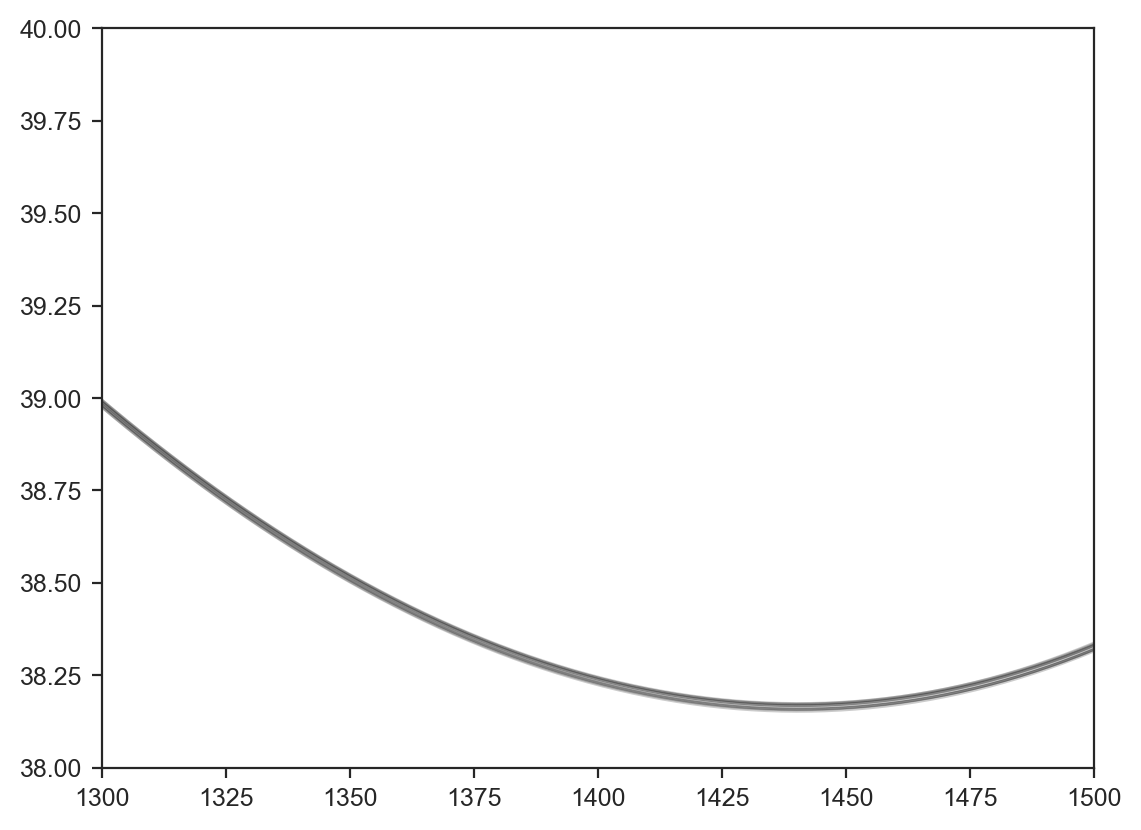

In [61]:
for res in order_1_res:
    plt.plot(x1, res, 'k', lw=1, alpha=0.2)

plt.xlim(1300, 1500)#1250, 1750
plt.ylim(38,40)

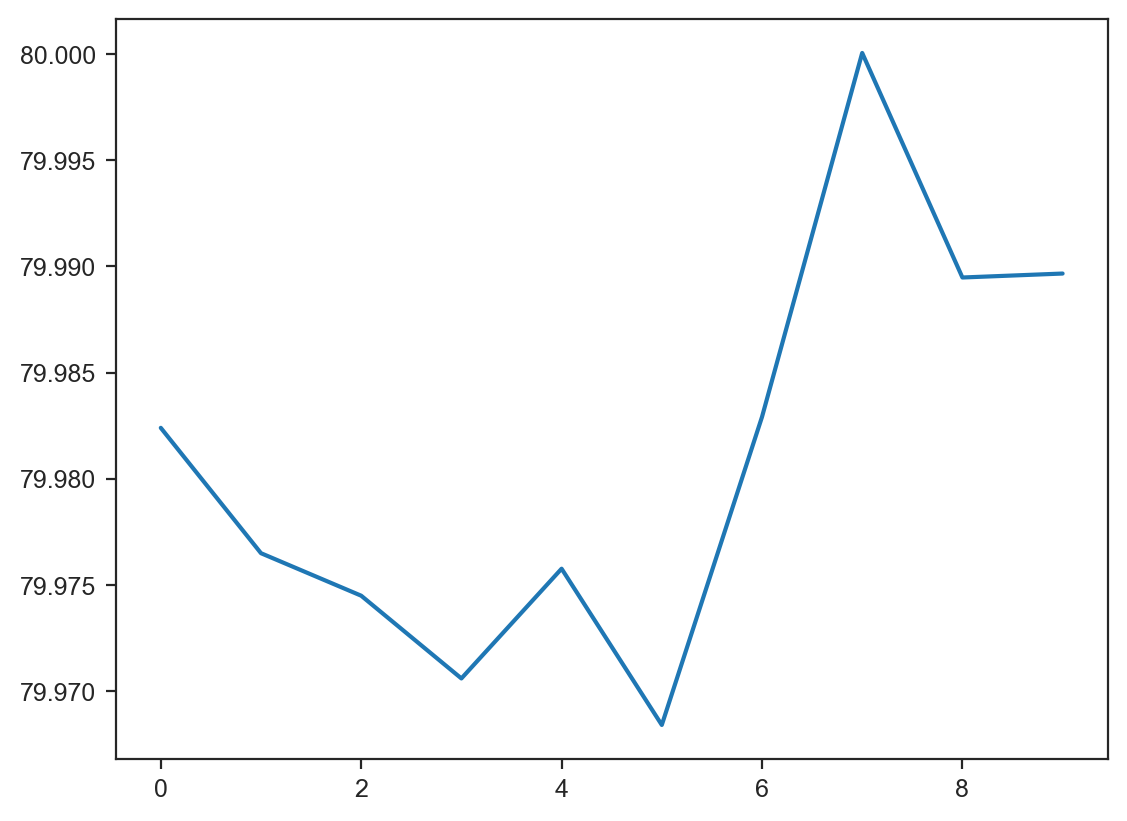

In [66]:
plt.plot(order_1_res[:,len(order_1_res)//2])

In [67]:
import os

In [ ]:
"../outputs/"

In [68]:
np.save("../outputs/test_tso_data.npy", tso)

In [69]:
test_tso = np.load("../outputs/test_tso_data.npy")

In [71]:
np.testing.assert_almost_equal(test_tso,tso)